### トポロジー転移：あるトポロジーから他のトポロジーへ
                            学習不要！！！
* ソースドメイン：単一Lを持つ非共振DABコンバータ
* ターゲットドメイン：LCレゾナントタンクを持つ共振DABコンバータ
    * ケース1：Lrは同じ、fr = 1.1fs（容量性）
    * ケース2：Lrは同じ、fr = 0.9fs（誘導性）
    * ケース3：Lrは同じ、fr = 1.0fs（抵抗性）

In [14]:
# ライブラリのインポート
import torch
from torch import nn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.animation import FuncAnimation
from utils.pann_net import PANN, EulerCell_DAB
from utils.pann_utils import evaluate, create_vpvs, get_inputs

# 日本語フォント設定
font_path = "/System/Library/Fonts/ヒラギノ角ゴシック W3.ttc"
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["axes.unicode_minus"] = False

# 回路パラメータとネットワーク変数を定義
n, RL, Lr = 1, 120e-3, 63e-6
Ts = 1/50e3
Tslen = 100
dt = Ts/Tslen

dab_Euler_cell = torch.jit.script(EulerCell_DAB(dt, Lr, RL, n)) # DAB用のオイラーセルを定義
pann_dab = torch.jit.script(PANN(dab_Euler_cell)) # DAB用のPANNを定義
print(pann_dab)

RecursiveScriptModule(
  original_name=PANN
  (cell): RecursiveScriptModule(original_name=EulerCell_DAB)
)


In [15]:
# 例示的なケースを考慮
D0, D1, D2 = 0.16, 1, 1
Vin, Vref = 200, 160
Tsim = 100*Ts # シミュレーション時間、スイッチング周期の100倍を考慮
# 変調パラメータのセットから電圧波形（vpとvs）を生成
vp, vs = create_vpvs(D0, D1, D2, Vin, Vref,
                     Tslen, dt, Tsim, Ts,
                     D1_cycle=0.5, D2_cycle=0.5)
t = np.arange(0, len(vp)*dt, dt)
inputs = np.hstack([vp[:, None], vs[:, None]])[None]
# torch FloatTensorに変換
inputs = torch.FloatTensor(inputs)
# 状態変数を初期化
state_dim = 1
state0 = torch.zeros((inputs.shape[0], 1, state_dim)) # 初期値は0
# PANNを使用して状態変数iLを推論
pann_dab.eval()
with torch.no_grad():
    # 学習ではないため、計算グラフをキャプチャしない
    states = pann_dab(inputs, state0)

In [16]:
# LCレゾナントタンクを持つDAB用の陰的オイラーセルを定義
class EulerCell_DAB_LC(nn.Module):
    # 直列LCタンクを持つDAB専用
    def __init__(self, dt, Lr, RL, n, Cs, **kwargs):
        super(EulerCell_DAB_LC, self).__init__(**kwargs)
        self.dt = dt
        self.Lr = nn.Parameter(torch.Tensor([Lr]))
        self.RL = nn.Parameter(torch.Tensor([RL]))
        self.n = nn.Parameter(torch.Tensor([n]))
        self.Cs = nn.Parameter(torch.Tensor([Cs]))

    def forward(self, inputs, states):
        # 従来の非共振DABの漏れインダクタの物理
        # iL_next = (states[:, 0]+(inputs[:, 0]-inputs[:, 1]*self.n)*self.dt/self.Lr)\/
        #             (1+self.RL*self.dt/self.Lr) # iLの物理

        # 共振インダクタiLの物理
        iL_next = (states[:, 0]+(inputs[:, 0]-inputs[:, 1]*self.n-states[:, 1])*self.dt/self.Lr)/\
                    (1+self.RL*self.dt/self.Lr+self.dt**2/self.Lr/self.Cs)
        # 共振コンデンサvCの物理
        vC_next = iL_next/self.Cs*self.dt+states[:, 1]

        states_next = torch.cat((iL_next[:, None], vC_next[:, None]), dim=-1)
        return states_next

In [17]:
##################################################
# ケース1: Lrは同じ、fr = 1.1fs
# 共振コンデンサンスを定義
fr = 1.1/Ts
Cs = 1/pann_dab.cell.Lr.item()/(2*np.pi*fr)**2

# LCレゾナントタンクを持つDABコンバータのPANNモデルを定義
dab_Euler_cell_LC = torch.jit.script(EulerCell_DAB_LC(dt, Lr, RL, n, Cs)) # DAB用のオイラーセルを定義
pann_dab_LC = torch.jit.script(PANN(dab_Euler_cell_LC)) # DAB用のPANNを定義

# 同じ入力を考慮
state_dim = 2 # 次元は2になる（iLとvCのそれぞれに対して）
state0 = torch.zeros((inputs.shape[0], 1, state_dim)) # 初期値は0
# PANNを使用して状態変数iLを推論
pann_dab_LC.eval()
with torch.no_grad():
    # 学習ではないため、計算グラフをキャプチャしない
    states_LC = pann_dab_LC(inputs, state0)


##################################################
# ケース2: Lrは同じ、fr = 0.9fs
# 共振コンデンサンスを定義
fr = 0.9/Ts
Cs = 1/pann_dab.cell.Lr.item()/(2*np.pi*fr)**2

# LCレゾナントタンクを持つDABコンバータのPANNモデルを定義
dab_Euler_cell_LC = torch.jit.script(EulerCell_DAB_LC(dt, Lr, RL, n, Cs)) # DAB用のオイラーセルを定義
pann_dab_LC = torch.jit.script(PANN(dab_Euler_cell_LC)) # DAB用のPANNを定義

# 同じ入力を考慮
state_dim = 2 # 次元は2になる（iLとvCのそれぞれに対して）
state0 = torch.zeros((inputs.shape[0], 1, state_dim)) # 初期値は0
# PANNを使用して状態変数iLを推論
pann_dab_LC.eval()
with torch.no_grad():
    # 学習ではないため、計算グラフをキャプチャしない
    states_LC2 = pann_dab_LC(inputs, state0)


##################################################
# ケース3: Lrは同じ、fr = 1.0fs
# 共振コンデンサンスを定義
fr = 1.0/Ts
Cs = 1/pann_dab.cell.Lr.item()/(2*np.pi*fr)**2

# LCレゾナントタンクを持つDABコンバータのPANNモデルを定義
dab_Euler_cell_LC = torch.jit.script(EulerCell_DAB_LC(dt, Lr, RL, n, Cs)) # DAB用のオイラーセルを定義
pann_dab_LC = torch.jit.script(PANN(dab_Euler_cell_LC)) # DAB用のPANNを定義

# 同じ入力を考慮
state_dim = 2 # 次元は2になる（iLとvCのそれぞれに対して）
state0 = torch.zeros((inputs.shape[0], 1, state_dim)) # 初期値は0
# PANNを使用して状態変数iLを推論
pann_dab_LC.eval()
with torch.no_grad():
    # 学習ではないため、計算グラフをキャプチャしない
    states_LC3 = pann_dab_LC(inputs, state0)

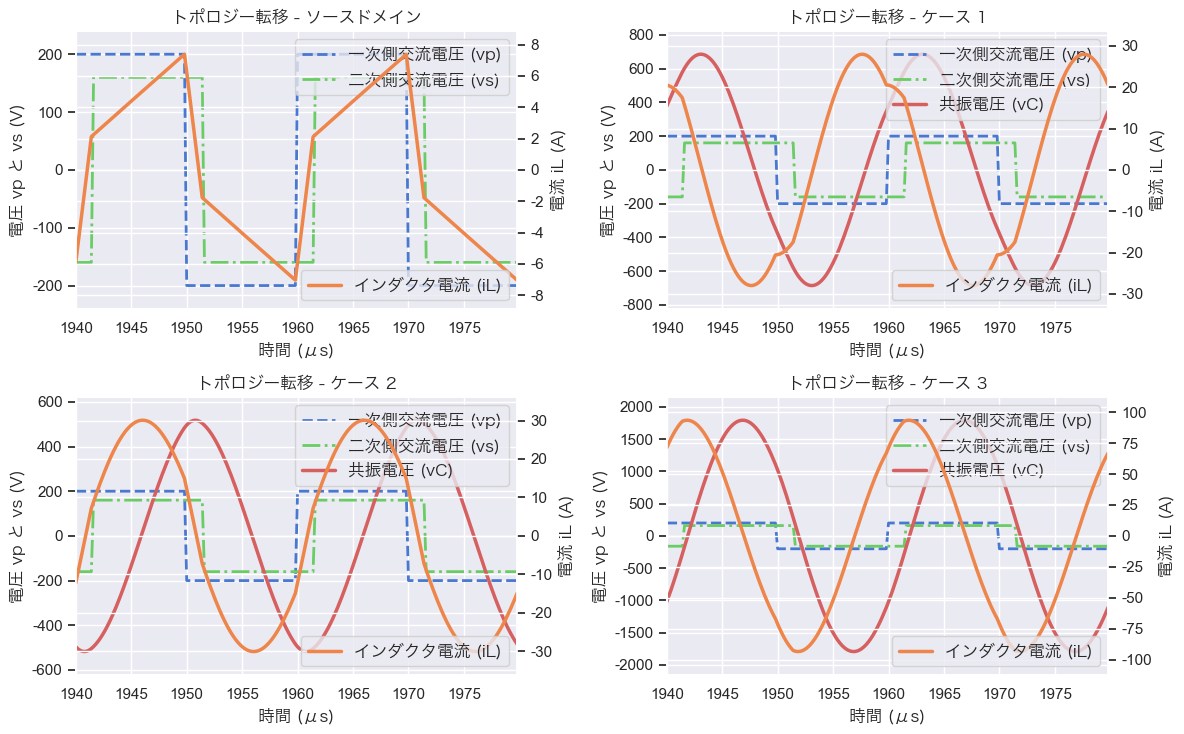

In [18]:
# 表示用データの準備
if len(inputs.shape) == 3:
    t = t[-2 * Tslen :] * 1e6
    inputs = inputs[0, -2 * Tslen :]
    states = states[0, -2 * Tslen :]
    states_LC = states_LC[0, -2 * Tslen :]
    states_LC2 = states_LC2[0, -2 * Tslen :]
    states_LC3 = states_LC3[0, -2 * Tslen :]

# vp、vsの例示データ
# inputs: サイズ (seqlen x inp_dim)
# states: サイズ (seqlen x state_dim)
sns.set_theme(style="darkgrid")  # コントラスト用の暗いグリッド背景を使用

t, inputs, states = np.array(t), inputs.numpy(), states.numpy()

# 図とサブプロット（2x2）を作成
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 7.5))

for i, (ax, _inputs, _states) in enumerate(
    zip(
        [ax1, ax2, ax3, ax4],
        [inputs, inputs, inputs, inputs],
        [states, states_LC, states_LC2, states_LC3],
    )
):
    # すべてのプロットの範囲を設定
    ax.set_xlim(t.min(), t.max())
    if i == 0:
        ax.set_ylim(-_inputs.max() * 1.2, _inputs.max() * 1.2)
    else:
        ax.set_ylim(
            -max(_inputs.max(), _states[:, 1].max()) * 1.2,
            max(_inputs.max(), _states[:, 1].max()) * 1.2,
        )
    ax_2 = ax.twinx()
    ax_2.set_ylim(-_states[:, 0].max() * 1.2, _states[:, 0].max() * 1.2)

    # ラベルとタイトル
    if i == 0:
        ax.set_title("トポロジー転移 - ソースドメイン", fontsize=16, weight="bold", fontproperties=font_prop)
    else:
        ax.set_title(f"トポロジー転移 - ケース {i}", fontsize=16, weight="bold", fontproperties=font_prop)
    ax.set_xlabel("時間 (μs)", fontsize=12, fontproperties=font_prop)
    ax.set_ylabel("電圧 vp と vs (V)", fontsize=12, fontproperties=font_prop)
    ax_2.set_ylabel("電流 iL (A)", fontsize=12, fontproperties=font_prop)

    # 電圧波形をプロット
    ax.plot(
        t,
        _inputs[:, 0],
        lw=2,
        label="一次側交流電圧 (vp)",
        color=sns.color_palette("muted")[0],
        linestyle="--",
    )
    ax.plot(
        t,
        _inputs[:, 1],
        lw=2,
        label="二次側交流電圧 (vs)",
        color=sns.color_palette("muted")[2],
        linestyle="-.",
    )

    # 電流波形をプロット
    ax_2.plot(
        t,
        _states[:, 0],
        lw=2.5,
        label="インダクタ電流 (iL)",
        color=sns.color_palette("muted")[1],
        linestyle="-",
    )

    # 共振電圧をプロット（非共振ケース以外）
    if i != 0:
        ax.plot(
            t,
            _states[:, 1],
            lw=2.5,
            label="共振電圧 (vC)",
            color=sns.color_palette("muted")[3],
            linestyle="-",
        )

    # グリッドと凡例を追加
    ax.grid(True)
    ax.legend(loc="upper right", fontsize=10, prop=font_prop)
    ax_2.legend(loc="lower right", fontsize=10, prop=font_prop)

# レイアウトを調整
plt.tight_layout()
plt.show()